# Gemma 7B Hyperparameter Tuning with Optuna

This notebook performs hyperparameter tuning for Gemma-7B using Optuna with 5 trials.

## Tuning Parameters:
- **Learning Rate**: Range [1e-5, 5e-4]
- **Batch Size**: [1, 2, 4]
- **Number of Epochs**: [1, 2, 3, 4, 5]

## Dataset:
- **Source**: FinancialPhraseBank with 100% annotator agreement
- **Quality**: Highest quality labels for reliable evaluation

## Process:
- 5 trials with Optuna optimization
- Memory clearing between trials
- 60-second wait between trials
- Objective: Maximize validation accuracy

In [1]:
# Install required packages
%pip install -q optuna
%pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
%pip install -q -U transformers==4.38.2
%pip install -q accelerate==0.32.0
%pip install -q -i https://pypi.org/simple/ bitsandbytes
%pip install -q -U datasets==2.16.1
%pip install -q -U trl==0.7.11
%pip install -q -U peft==0.10.0
%pip install tensorboard


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings
import time
import gc
import shutil
from datetime import datetime

# Set environment variables
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import optuna

import torch
import torch.nn as nn

import transformers
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    BitsAndBytesConfig, 
    TrainingArguments, 
    pipeline, 
    logging
)
from datasets import Dataset, load_dataset
from peft import LoraConfig, PeftConfig
import bitsandbytes as bnb
from trl import SFTTrainer

from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix
)
from sklearn.model_selection import train_test_split

print(f"transformers=={transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Optuna version: {optuna.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

transformers==4.38.2
PyTorch version: 2.5.1+cu121
CUDA available: True
Optuna version: 4.3.0


## Load and Prepare Dataset

In [3]:
print("Loading FinancialPhraseBank dataset with 100% annotator agreement...")

# Load the dataset from HuggingFace
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree")

print(f"Dataset loaded successfully!")
print(f"Dataset info: {dataset}")

# Convert to pandas for easier manipulation
df = dataset['train'].to_pandas()
df = df.rename(columns={'sentence': 'text', 'label': 'sentiment'})

print(f"\nDataset shape: {df.shape}")
print(f"Sentiment distribution:")
print(df['sentiment'].value_counts())

# Create balanced splits for each sentiment class
X_train = []
X_val = []
X_test = []

random_state = 42
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

# Use smaller splits for hyperparameter tuning to speed up process
train_size_per_class = 100  # Reduced for faster tuning
val_size_per_class = 30
test_size_per_class = 30

for sentiment_label in [0, 1, 2]:
    sentiment_name = label_mapping[sentiment_label]
    sentiment_data = df[df.sentiment == sentiment_label]
    print(f"\nProcessing {sentiment_name} sentiment: {len(sentiment_data)} samples")
    
    if len(sentiment_data) == 0:
        continue
    
    # Adjust split sizes if needed
    actual_test_size = min(test_size_per_class, len(sentiment_data) // 3)
    actual_val_size = min(val_size_per_class, len(sentiment_data) // 3)
    actual_train_size = min(train_size_per_class, len(sentiment_data) - actual_test_size - actual_val_size)
    
    # Split data
    if actual_test_size > 0:
        temp_data, test_data = train_test_split(
            sentiment_data, 
            test_size=actual_test_size,
            random_state=random_state
        )
    else:
        temp_data = sentiment_data
        test_data = pd.DataFrame()
    
    if actual_val_size > 0 and len(temp_data) > actual_val_size:
        train_data, val_data = train_test_split(
            temp_data,
            test_size=actual_val_size,
            train_size=actual_train_size,
            random_state=random_state
        )
    else:
        train_data = temp_data
        val_data = pd.DataFrame()
    
    print(f"  Final sizes - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    
    if len(train_data) > 0:
        X_train.append(train_data)
    if len(val_data) > 0:
        X_val.append(val_data)
    if len(test_data) > 0:
        X_test.append(test_data)

# Combine and shuffle
X_train = pd.concat(X_train).sample(frac=1, random_state=10).reset_index(drop=True)
X_val = pd.concat(X_val).sample(frac=1, random_state=10).reset_index(drop=True)
X_test = pd.concat(X_test).sample(frac=1, random_state=10).reset_index(drop=True)

print(f"\nFinal split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

print(f"\nTraining set distribution:")
print(X_train['sentiment'].value_counts())
print(f"\nValidation set distribution:")
print(X_val['sentiment'].value_counts())

Loading FinancialPhraseBank dataset with 100% annotator agreement...
Dataset loaded successfully!
Dataset info: DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

Dataset shape: (2264, 2)
Sentiment distribution:
sentiment
1    1391
2     570
0     303
Name: count, dtype: int64

Processing negative sentiment: 303 samples
  Final sizes - Train: 100, Val: 30, Test: 30

Processing neutral sentiment: 1391 samples
  Final sizes - Train: 100, Val: 30, Test: 30

Processing positive sentiment: 570 samples
  Final sizes - Train: 100, Val: 30, Test: 30

Final split sizes:
Training set: 300 samples
Validation set: 90 samples
Test set: 90 samples

Training set distribution:
sentiment
0    100
1    100
2    100
Name: count, dtype: int64

Validation set distribution:
sentiment
2    30
0    30
1    30
Name: count, dtype: int64


## Define Helper Functions

In [4]:
def clear_memory():
    """Clear GPU and system memory"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()
    print("Memory cleared")

def generate_prompt(data_point, include_answer=True):
    """Generate training prompt"""
    label_mapping = {0: "negative", 1: "neutral", 2: "positive"}
    
    base_prompt = f"""Analyze the sentiment of the news headline enclosed in square brackets, 
determine if it is positive, neutral, or negative, and return the answer as 
the corresponding sentiment label "positive" or "neutral" or "negative"

[{data_point["text"]}] = """.strip()
    
    if include_answer:
        sentiment_text = label_mapping[data_point["sentiment"]]
        return base_prompt + sentiment_text + "</s>"  # Use Gemma's EOS token
    else:
        return base_prompt

def evaluate_model(model, tokenizer, X_val):
    """Evaluate model on validation set and return accuracy"""
    y_true = []
    y_pred = []
    label_mapping = {0: "negative", 1: "neutral", 2: "positive"}
    
    model.eval()
    with torch.no_grad():
        for _, row in X_val.iterrows():
            prompt = generate_prompt(row, include_answer=False)
            input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to("cuda")
            
            outputs = model.generate(
                **input_ids, 
                max_new_tokens=1, 
                temperature=0.0,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
            
            result = tokenizer.decode(outputs[0])
            answer = result.split("=")[-1].lower().strip()
            
            # Extract predicted sentiment
            if "positive" in answer:
                predicted_sentiment = "positive"
            elif "negative" in answer:
                predicted_sentiment = "negative"
            elif "neutral" in answer:
                predicted_sentiment = "neutral"
            else:
                predicted_sentiment = "neutral"  # Default fallback
            
            true_sentiment = label_mapping[row["sentiment"]]
            
            y_true.append(true_sentiment)
            y_pred.append(predicted_sentiment)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

print("Helper functions defined!")

Helper functions defined!


## Define Optuna Objective Function

In [5]:
def objective(trial):
    """Optuna objective function to maximize validation accuracy"""
    
    print(f"\n{'='*60}")
    print(f"TRIAL {trial.number + 1}")
    print(f"{'='*60}")
    
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4])
    num_epochs = trial.suggest_int('num_epochs', 1, 5)
    
    print(f"Hyperparameters for Trial {trial.number + 1}:")
    print(f"  Learning Rate: {learning_rate:.2e}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Number of Epochs: {num_epochs}")
    
    try:
        # Clear memory before starting
        clear_memory()
        
        # Load fresh model for this trial
        print("\nLoading fresh Gemma model...")
        model_name = "google/gemma-7b"
        
        compute_dtype = getattr(torch, "float16")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=False,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=compute_dtype,
        )
        
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=bnb_config,
        )
        
        model.config.use_cache = False
        model.config.pretraining_tp = 1
        
        # Load tokenizer
        max_seq_length = 2048
        tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
        
        # Prepare training data
        print("Preparing training data...")
        train_prompts = pd.DataFrame(
            X_train.apply(lambda x: generate_prompt(x, include_answer=True), axis=1), 
            columns=["text"]
        )
        
        val_prompts = pd.DataFrame(
            X_val.apply(lambda x: generate_prompt(x, include_answer=True), axis=1), 
            columns=["text"]
        )
        
        train_data = Dataset.from_pandas(train_prompts)
        eval_data = Dataset.from_pandas(val_prompts)
        
        # Configure LoRA
        peft_config = LoraConfig(
            lora_alpha=16,
            lora_dropout=0,
            r=64,
            bias="none",
            task_type="CAUSAL_LM",
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                            "gate_proj", "up_proj", "down_proj"],
        )
        
        # Configure training arguments
        output_dir = f"temp_trial_{trial.number}"
        training_steps = len(train_data) // (batch_size * 8)  # Assuming grad_accum=8
        
        training_arguments = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            gradient_checkpointing=True,
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=8,
            optim="paged_adamw_32bit",
            save_steps=0,  # Don't save checkpoints
            logging_steps=max(training_steps // 5, 1),
            learning_rate=learning_rate,
            weight_decay=0.001,
            fp16=True,
            bf16=False,
            max_grad_norm=0.3,
            max_steps=-1,
            warmup_ratio=0.03,
            group_by_length=False,
            evaluation_strategy='no',  # Skip evaluation during training for speed
            lr_scheduler_type="cosine",
            report_to=None,  # Disable reporting for speed
        )
        
        # Initialize trainer
        trainer = SFTTrainer(
            model=model,
            train_dataset=train_data,
            eval_dataset=eval_data,
            peft_config=peft_config,
            dataset_text_field="text",
            tokenizer=tokenizer,
            max_seq_length=max_seq_length,
            args=training_arguments,
            packing=False,
        )
        
        # Train the model
        print(f"\nStarting training for {num_epochs} epochs...")
        trainer.train()
        
        # Evaluate the model
        print("\nEvaluating model...")
        accuracy = evaluate_model(model, tokenizer, X_val)
        
        print(f"\nTrial {trial.number + 1} Results:")
        print(f"  Validation Accuracy: {accuracy:.4f}")
        
        # Clean up
        del model
        del trainer
        del tokenizer
        
        # Remove temporary directory
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        
        clear_memory()
        
        return accuracy
        
    except Exception as e:
        print(f"\nError in trial {trial.number + 1}: {str(e)}")
        # Clean up on error
        clear_memory()
        return 0.0  # Return low score for failed trials

print("Objective function defined!")

Objective function defined!


## Run Hyperparameter Tuning

In [6]:
print("Starting Optuna hyperparameter tuning...")
print(f"Number of trials: 5")
print(f"Wait time between trials: 60 seconds")

# Create Optuna study
study_name = f"gemma_hyperparameter_tuning_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
study = optuna.create_study(
    direction='maximize',  # Maximize validation accuracy
    study_name=study_name,
    storage=f'sqlite:///{study_name}.db',
    load_if_exists=True
)

print(f"Study created: {study_name}")

# Run optimization
for trial_num in range(5):
    print(f"\n{'='*80}")
    print(f"STARTING TRIAL {trial_num + 1} OF 5")
    print(f"{'='*80}")
    
    # Run single trial
    study.optimize(objective, n_trials=1)
    
    # Print current best
    print(f"\nCurrent best trial:")
    print(f"  Trial number: {study.best_trial.number + 1}")
    print(f"  Best accuracy: {study.best_value:.4f}")
    print(f"  Best parameters: {study.best_params}")
    
    # Wait between trials (except after the last one)
    if trial_num < 4:
        print(f"\nWaiting 60 seconds before next trial...")
        time.sleep(60)
        clear_memory()

print(f"\n{'='*80}")
print(f"HYPERPARAMETER TUNING COMPLETED!")
print(f"{'='*80}")

Starting Optuna hyperparameter tuning...
Number of trials: 5
Wait time between trials: 60 seconds


[I 2025-07-01 01:24:05,136] A new study created in RDB with name: gemma_hyperparameter_tuning_20250701_012404


Study created: gemma_hyperparameter_tuning_20250701_012404

STARTING TRIAL 1 OF 5

TRIAL 1
Hyperparameters for Trial 1:
  Learning Rate: 1.50e-05
  Batch Size: 2
  Number of Epochs: 4
Memory cleared

Loading fresh Gemma model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Preparing training data...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]


Starting training for 4 epochs...


  0%|          | 0/72 [00:00<?, ?it/s]

{'loss': 6.09, 'grad_norm': 35.69955825805664, 'learning_rate': 4.997815301102062e-06, 'epoch': 0.16}
{'loss': 5.3851, 'grad_norm': nan, 'learning_rate': 9.995630602204123e-06, 'epoch': 0.32}
{'loss': 5.7938, 'grad_norm': inf, 'learning_rate': 1.4985676851748206e-05, 'epoch': 0.48}
{'loss': 4.0691, 'grad_norm': 264.4466552734375, 'learning_rate': 1.4869462862362575e-05, 'epoch': 0.64}
{'loss': 2.6681, 'grad_norm': 4.349188327789307, 'learning_rate': 1.461590867820005e-05, 'epoch': 0.8}
{'loss': 2.3802, 'grad_norm': 3.7852556705474854, 'learning_rate': 1.422973753396864e-05, 'epoch': 0.96}
{'loss': 2.1332, 'grad_norm': 2.3727943897247314, 'learning_rate': 1.3718143067421515e-05, 'epoch': 1.12}
{'loss': 1.972, 'grad_norm': 1.9359291791915894, 'learning_rate': 1.3090655315496539e-05, 'epoch': 1.28}
{'loss': 1.6785, 'grad_norm': 2.0539944171905518, 'learning_rate': 1.2358963187759657e-05, 'epoch': 1.44}
{'loss': 1.4582, 'grad_norm': 4.3124165534973145, 'learning_rate': 1.1536696724135934e-

[I 2025-07-01 01:45:03,996] Trial 0 finished with value: 0.8888888888888888 and parameters: {'learning_rate': 1.4993445903306187e-05, 'batch_size': 2, 'num_epochs': 4}. Best is trial 0 with value: 0.8888888888888888.


Memory cleared

Current best trial:
  Trial number: 1
  Best accuracy: 0.8889
  Best parameters: {'learning_rate': 1.4993445903306187e-05, 'batch_size': 2, 'num_epochs': 4}

Waiting 60 seconds before next trial...
Memory cleared

STARTING TRIAL 2 OF 5

TRIAL 2
Hyperparameters for Trial 2:
  Learning Rate: 9.42e-05
  Batch Size: 1
  Number of Epochs: 4
Memory cleared

Loading fresh Gemma model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Preparing training data...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]


Starting training for 4 epochs...


  0%|          | 0/148 [00:00<?, ?it/s]

{'loss': 2.5723, 'grad_norm': 2.32041072845459, 'learning_rate': 9.423217301629628e-05, 'epoch': 0.19}
{'loss': 1.2924, 'grad_norm': 1.3352062702178955, 'learning_rate': 9.351763698107881e-05, 'epoch': 0.37}
{'loss': 1.038, 'grad_norm': 1.5407686233520508, 'learning_rate': 9.170801816609864e-05, 'epoch': 0.56}
{'loss': 0.9496, 'grad_norm': 1.702755093574524, 'learning_rate': 8.884602905026188e-05, 'epoch': 0.75}
{'loss': 0.7917, 'grad_norm': 0.729846715927124, 'learning_rate': 8.499922123544612e-05, 'epoch': 0.93}
{'loss': 0.7386, 'grad_norm': 0.9947212338447571, 'learning_rate': 8.025839102432352e-05, 'epoch': 1.12}
{'loss': 0.7052, 'grad_norm': 0.6794397234916687, 'learning_rate': 7.473543635292007e-05, 'epoch': 1.31}
{'loss': 0.6532, 'grad_norm': 0.759273886680603, 'learning_rate': 6.85607156607861e-05, 'epoch': 1.49}
{'loss': 0.674, 'grad_norm': 0.9265498518943787, 'learning_rate': 6.187997103743279e-05, 'epoch': 1.68}
{'loss': 0.672, 'grad_norm': 0.693241536617279, 'learning_rate'

[I 2025-07-01 02:32:20,834] Trial 1 finished with value: 0.9777777777777777 and parameters: {'learning_rate': 9.424354409907966e-05, 'batch_size': 1, 'num_epochs': 4}. Best is trial 1 with value: 0.9777777777777777.


Memory cleared

Current best trial:
  Trial number: 2
  Best accuracy: 0.9778
  Best parameters: {'learning_rate': 9.424354409907966e-05, 'batch_size': 1, 'num_epochs': 4}

Waiting 60 seconds before next trial...
Memory cleared

STARTING TRIAL 3 OF 5

TRIAL 3
Hyperparameters for Trial 3:
  Learning Rate: 5.43e-05
  Batch Size: 2
  Number of Epochs: 4
Memory cleared

Loading fresh Gemma model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Preparing training data...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]


Starting training for 4 epochs...


  0%|          | 0/72 [00:00<?, ?it/s]

{'loss': 6.09, 'grad_norm': 36.35741424560547, 'learning_rate': 1.808944898904157e-05, 'epoch': 0.16}
{'loss': 5.3329, 'grad_norm': nan, 'learning_rate': 3.617889797808314e-05, 'epoch': 0.32}
{'loss': 5.2601, 'grad_norm': 259.9085388183594, 'learning_rate': 5.424022710806943e-05, 'epoch': 0.48}
{'loss': 2.3732, 'grad_norm': 2.334230661392212, 'learning_rate': 5.3819593910131755e-05, 'epoch': 0.64}
{'loss': 1.7342, 'grad_norm': 1.7906463146209717, 'learning_rate': 5.290186182040154e-05, 'epoch': 0.8}
{'loss': 1.2313, 'grad_norm': 2.0194311141967773, 'learning_rate': 5.150412645129466e-05, 'epoch': 0.96}
{'loss': 1.0819, 'grad_norm': 1.427247405052185, 'learning_rate': 4.965242496812071e-05, 'epoch': 1.12}
{'loss': 1.0419, 'grad_norm': 1.4029343128204346, 'learning_rate': 4.738125106595745e-05, 'epoch': 1.28}
{'loss': 0.9272, 'grad_norm': 1.4805622100830078, 'learning_rate': 4.473291241737614e-05, 'epoch': 1.44}
{'loss': 0.9426, 'grad_norm': 0.863046407699585, 'learning_rate': 4.17567425

[I 2025-07-01 05:03:40,648] Trial 2 finished with value: 0.9555555555555556 and parameters: {'learning_rate': 5.426834696712471e-05, 'batch_size': 2, 'num_epochs': 4}. Best is trial 1 with value: 0.9777777777777777.


Memory cleared

Current best trial:
  Trial number: 2
  Best accuracy: 0.9778
  Best parameters: {'learning_rate': 9.424354409907966e-05, 'batch_size': 1, 'num_epochs': 4}

Waiting 60 seconds before next trial...
Memory cleared

STARTING TRIAL 4 OF 5

TRIAL 4
Hyperparameters for Trial 4:
  Learning Rate: 6.46e-05
  Batch Size: 1
  Number of Epochs: 3
Memory cleared

Loading fresh Gemma model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Preparing training data...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]


Starting training for 3 epochs...


  0%|          | 0/111 [00:00<?, ?it/s]

{'loss': 2.6115, 'grad_norm': 2.2148995399475098, 'learning_rate': 6.457677108943598e-05, 'epoch': 0.19}
{'loss': 1.4538, 'grad_norm': 11.296846389770508, 'learning_rate': 6.351076449217572e-05, 'epoch': 0.37}
{'loss': 1.0813, 'grad_norm': 1.8572674989700317, 'learning_rate': 6.113171948984946e-05, 'epoch': 0.56}
{'loss': 1.0045, 'grad_norm': 0.9116963744163513, 'learning_rate': 5.7539774715090635e-05, 'epoch': 0.75}
{'loss': 0.8406, 'grad_norm': 0.8572925925254822, 'learning_rate': 5.288612211167813e-05, 'epoch': 0.93}
{'loss': 0.7772, 'grad_norm': 1.0090490579605103, 'learning_rate': 4.73666429714753e-05, 'epoch': 1.12}
{'loss': 0.7426, 'grad_norm': 0.8094181418418884, 'learning_rate': 4.1213662909763995e-05, 'epoch': 1.31}
{'loss': 0.684, 'grad_norm': 0.8464077115058899, 'learning_rate': 3.4686172828102645e-05, 'epoch': 1.49}
{'loss': 0.704, 'grad_norm': 0.8889649510383606, 'learning_rate': 2.8058927483407033e-05, 'epoch': 1.68}
{'loss': 0.7204, 'grad_norm': 0.7738547921180725, 'lea

[I 2025-07-01 06:29:38,762] Trial 3 finished with value: 0.9555555555555556 and parameters: {'learning_rate': 6.463247146906411e-05, 'batch_size': 1, 'num_epochs': 3}. Best is trial 1 with value: 0.9777777777777777.


Memory cleared

Current best trial:
  Trial number: 2
  Best accuracy: 0.9778
  Best parameters: {'learning_rate': 9.424354409907966e-05, 'batch_size': 1, 'num_epochs': 4}

Waiting 60 seconds before next trial...
Memory cleared

STARTING TRIAL 5 OF 5

TRIAL 5
Hyperparameters for Trial 5:
  Learning Rate: 4.46e-05
  Batch Size: 2
  Number of Epochs: 1
Memory cleared

Loading fresh Gemma model...

Error in trial 5: 
                    Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the
                    quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules
                    in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to
                    `from_pretrained`. Check
                    https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu
                    for more details.
                   

[I 2025-07-01 06:30:39,678] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 4.46364938889645e-05, 'batch_size': 2, 'num_epochs': 1}. Best is trial 1 with value: 0.9777777777777777.



Current best trial:
  Trial number: 2
  Best accuracy: 0.9778
  Best parameters: {'learning_rate': 9.424354409907966e-05, 'batch_size': 1, 'num_epochs': 4}

HYPERPARAMETER TUNING COMPLETED!


## Results Analysis

In [7]:
print("HYPERPARAMETER TUNING RESULTS")
print("=" * 60)

# Best trial information
best_trial = study.best_trial
print(f"\nBest Trial: #{best_trial.number + 1}")
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in best_trial.params.items():
    if key == 'learning_rate':
        print(f"  {key}: {value:.2e}")
    else:
        print(f"  {key}: {value}")

# All trials summary
print(f"\nAll Trials Summary:")
print(f"{'Trial':<6} {'Learning Rate':<15} {'Batch Size':<12} {'Epochs':<8} {'Accuracy':<10}")
print("-" * 60)

for trial in study.trials:
    trial_num = trial.number + 1
    lr = trial.params.get('learning_rate', 'N/A')
    batch_size = trial.params.get('batch_size', 'N/A')
    epochs = trial.params.get('num_epochs', 'N/A')
    accuracy = trial.value if trial.value is not None else 0.0
    
    lr_str = f"{lr:.2e}" if lr != 'N/A' else 'N/A'
    print(f"{trial_num:<6} {lr_str:<15} {batch_size:<12} {epochs:<8} {accuracy:<10.4f}")

# Create results dataframe
results_data = []
for trial in study.trials:
    results_data.append({
        'trial_number': trial.number + 1,
        'learning_rate': trial.params.get('learning_rate', None),
        'batch_size': trial.params.get('batch_size', None),
        'num_epochs': trial.params.get('num_epochs', None),
        'validation_accuracy': trial.value if trial.value is not None else 0.0,
        'trial_state': trial.state.name
    })

results_df = pd.DataFrame(results_data)

# Save results
results_filename = f"../results/gemma_hyperparameter_tuning_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
results_df.to_csv(results_filename, index=False)
print(f"\nResults saved to: {results_filename}")

# Analysis insights
print(f"\nKey Insights:")
print(f"  • Total trials completed: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"  • Best accuracy achieved: {study.best_value:.4f}")
print(f"  • Accuracy range: {results_df['validation_accuracy'].min():.4f} - {results_df['validation_accuracy'].max():.4f}")

if len(results_df) > 1:
    print(f"  • Standard deviation: {results_df['validation_accuracy'].std():.4f}")

# Parameter analysis
completed_trials = results_df[results_df['trial_state'] == 'COMPLETE']
if len(completed_trials) > 0:
    print(f"\nParameter Analysis:")
    print(f"  • Learning rate range: {completed_trials['learning_rate'].min():.2e} - {completed_trials['learning_rate'].max():.2e}")
    print(f"  • Batch sizes tested: {sorted(completed_trials['batch_size'].unique())}")
    print(f"  • Epochs range: {completed_trials['num_epochs'].min()} - {completed_trials['num_epochs'].max()}")

HYPERPARAMETER TUNING RESULTS

Best Trial: #2
Best Validation Accuracy: 0.9778

Best Hyperparameters:
  learning_rate: 9.42e-05
  batch_size: 1
  num_epochs: 4

All Trials Summary:
Trial  Learning Rate   Batch Size   Epochs   Accuracy  
------------------------------------------------------------
1      1.50e-05        2            4        0.8889    
2      9.42e-05        1            4        0.9778    
3      5.43e-05        2            4        0.9556    
4      6.46e-05        1            3        0.9556    
5      4.46e-05        2            1        0.0000    

Results saved to: ../results/gemma_hyperparameter_tuning_results_20250701_063039.csv

Key Insights:
  • Total trials completed: 5
  • Best accuracy achieved: 0.9778
  • Accuracy range: 0.0000 - 0.9778
  • Standard deviation: 0.4237

Parameter Analysis:
  • Learning rate range: 1.50e-05 - 9.42e-05
  • Batch sizes tested: [1, 2]
  • Epochs range: 1 - 4


## Visualization

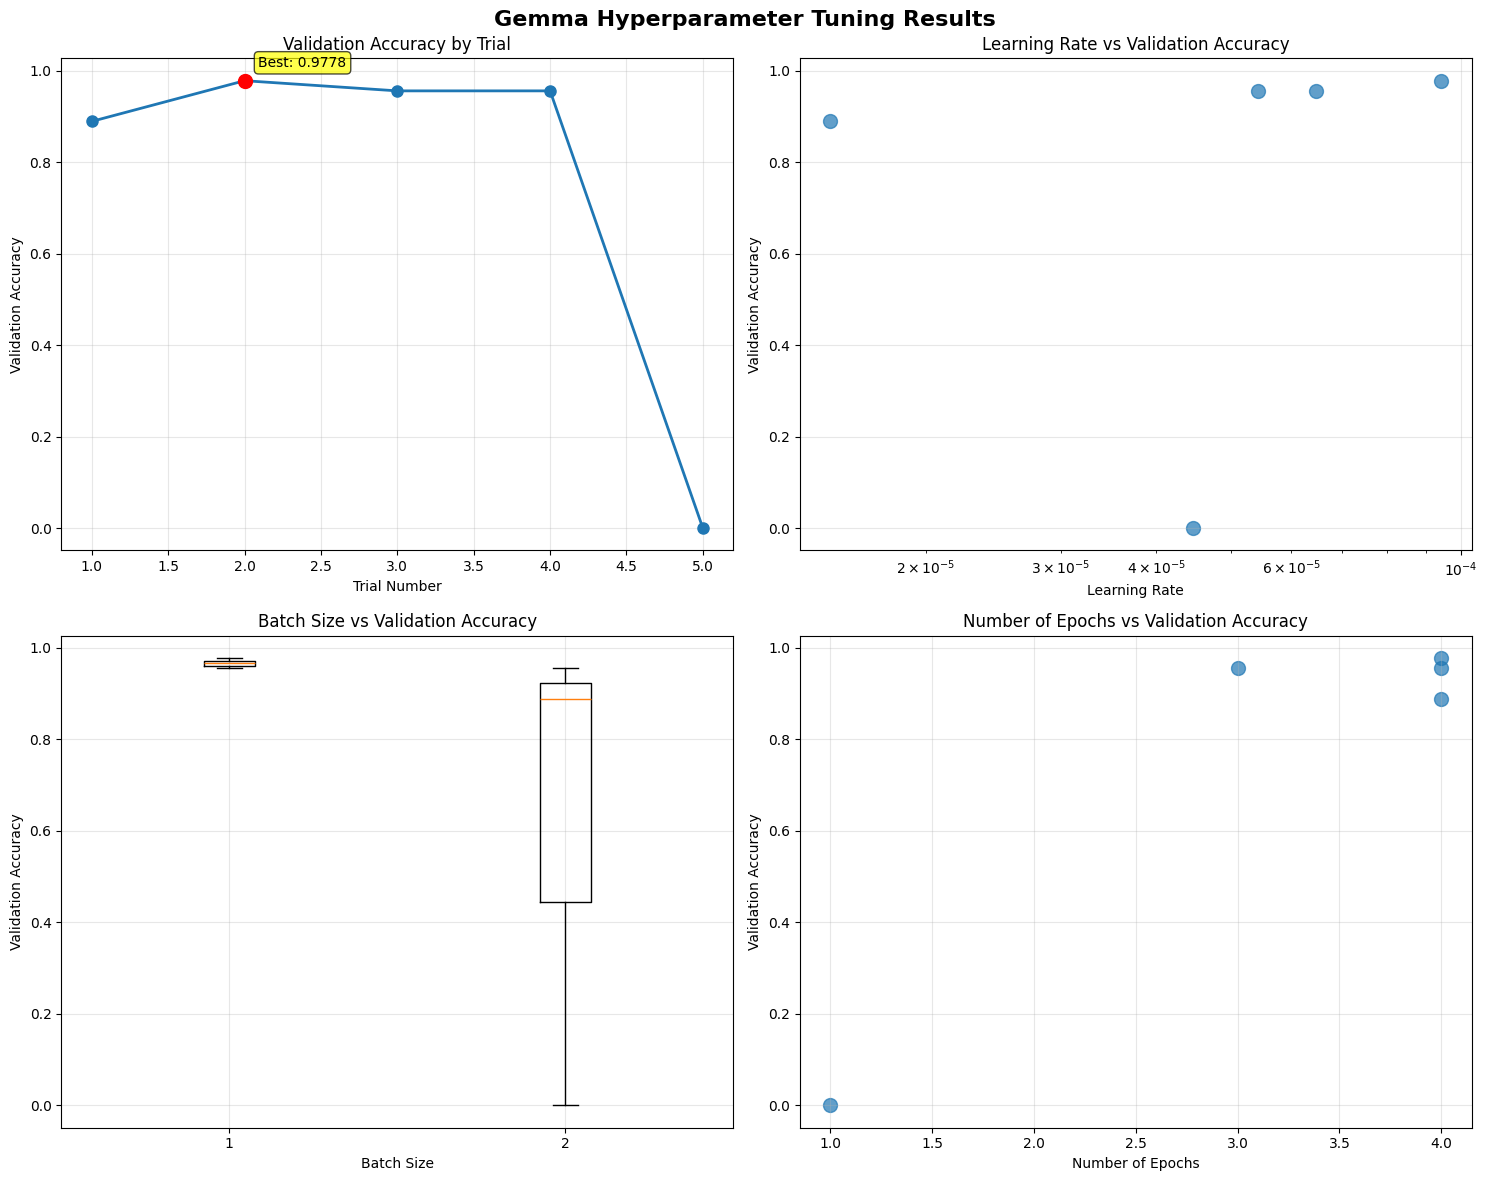

Plots saved to: ../results/gemma_hyperparameter_tuning_plots_20250701_063040.png


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Gemma Hyperparameter Tuning Results', fontsize=16, fontweight='bold')

completed_df = results_df[results_df['trial_state'] == 'COMPLETE']

if len(completed_df) > 0:
    # 1. Trial progression
    axes[0, 0].plot(completed_df['trial_number'], completed_df['validation_accuracy'], 
                    marker='o', linewidth=2, markersize=8)
    axes[0, 0].set_title('Validation Accuracy by Trial')
    axes[0, 0].set_xlabel('Trial Number')
    axes[0, 0].set_ylabel('Validation Accuracy')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Highlight best trial
    best_idx = completed_df['validation_accuracy'].idxmax()
    best_trial_num = completed_df.loc[best_idx, 'trial_number']
    best_accuracy = completed_df.loc[best_idx, 'validation_accuracy']
    axes[0, 0].scatter([best_trial_num], [best_accuracy], color='red', s=100, zorder=5)
    axes[0, 0].annotate(f'Best: {best_accuracy:.4f}', 
                        xy=(best_trial_num, best_accuracy),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # 2. Learning rate vs accuracy
    axes[0, 1].scatter(completed_df['learning_rate'], completed_df['validation_accuracy'], 
                       alpha=0.7, s=100)
    axes[0, 1].set_title('Learning Rate vs Validation Accuracy')
    axes[0, 1].set_xlabel('Learning Rate')
    axes[0, 1].set_ylabel('Validation Accuracy')
    axes[0, 1].set_xscale('log')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Batch size vs accuracy
    batch_sizes = sorted(completed_df['batch_size'].unique())
    batch_accuracies = [completed_df[completed_df['batch_size'] == bs]['validation_accuracy'].values 
                        for bs in batch_sizes]
    
    axes[1, 0].boxplot(batch_accuracies, labels=batch_sizes)
    axes[1, 0].set_title('Batch Size vs Validation Accuracy')
    axes[1, 0].set_xlabel('Batch Size')
    axes[1, 0].set_ylabel('Validation Accuracy')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Epochs vs accuracy
    axes[1, 1].scatter(completed_df['num_epochs'], completed_df['validation_accuracy'], 
                       alpha=0.7, s=100)
    axes[1, 1].set_title('Number of Epochs vs Validation Accuracy')
    axes[1, 1].set_xlabel('Number of Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_filename = f"../results/gemma_hyperparameter_tuning_plots_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plots saved to: {plot_filename}")
else:
    print("No completed trials to visualize")
    plt.close(fig)

## Recommendations

In [9]:
print("RECOMMENDATIONS BASED ON HYPERPARAMETER TUNING")
print("=" * 60)

if len(completed_df) > 0:
    # Best configuration
    best_config = study.best_params
    print(f"\n RECOMMENDED CONFIGURATION:")
    print(f"  Learning Rate: {best_config['learning_rate']:.2e}")
    print(f"  Batch Size: {best_config['batch_size']}")
    print(f"  Number of Epochs: {best_config['num_epochs']}")
    print(f"  Expected Accuracy: {study.best_value:.4f}")
    
    # Analysis by parameter
    print(f"\n PARAMETER ANALYSIS:")
    
    # Learning rate analysis
    lr_analysis = completed_df.groupby('learning_rate')['validation_accuracy'].agg(['mean', 'std', 'count'])
    best_lr = lr_analysis['mean'].idxmax()
    print(f"\nLearning Rate:")
    print(f"  Best performing: {best_lr:.2e} (avg accuracy: {lr_analysis.loc[best_lr, 'mean']:.4f})")
    
    # Batch size analysis
    bs_analysis = completed_df.groupby('batch_size')['validation_accuracy'].agg(['mean', 'std', 'count'])
    best_bs = bs_analysis['mean'].idxmax()
    print(f"\nBatch Size:")
    print(f"  Best performing: {best_bs} (avg accuracy: {bs_analysis.loc[best_bs, 'mean']:.4f})")
    
    # Epochs analysis
    epoch_analysis = completed_df.groupby('num_epochs')['validation_accuracy'].agg(['mean', 'std', 'count'])
    best_epochs = epoch_analysis['mean'].idxmax()
    print(f"\nNumber of Epochs:")
    print(f"  Best performing: {best_epochs} (avg accuracy: {epoch_analysis.loc[best_epochs, 'mean']:.4f})")
    
    # General insights
    print(f"\n KEY INSIGHTS:")
    
    accuracy_range = completed_df['validation_accuracy'].max() - completed_df['validation_accuracy'].min()
    if accuracy_range > 0.05:
        print(f"  • Hyperparameters have significant impact (range: {accuracy_range:.4f})")
    else:
        print(f"  • Hyperparameters have moderate impact (range: {accuracy_range:.4f})")
    
    # Learning rate insights
    lr_values = completed_df['learning_rate'].values
    if len(lr_values) > 1:
        lr_corr = np.corrcoef(lr_values, completed_df['validation_accuracy'].values)[0, 1]
        if lr_corr > 0.3:
            print(f"  • Higher learning rates tend to perform better")
        elif lr_corr < -0.3:
            print(f"  • Lower learning rates tend to perform better")
        else:
            print(f"  • Learning rate shows no clear linear trend")
    
    # Training recommendations
    print(f"\n TRAINING RECOMMENDATIONS:")
    print(f"  • Use the best configuration for final model training")
    print(f"  • Consider training for more epochs if computational budget allows")
    print(f"  • Monitor validation performance to avoid overfitting")
    
    if study.best_value < 0.8:
        print(f"  • Consider additional hyperparameter tuning (rank, alpha, dropout)")
        print(f"  • Experiment with different model architectures")
    
else:
    print("\n  No completed trials to analyze")
    print("Please check for errors and rerun the tuning process")

print(f"\ OUTPUT FILES:")
print(f"  • Results CSV: {results_filename}")
if 'plot_filename' in locals():
    print(f"  • Visualization: {plot_filename}")
print(f"  • Optuna database: {study_name}.db")

print(f"\n Hyperparameter tuning analysis complete!")
print(f"Use the recommended configuration for training your final Gemma model.")

RECOMMENDATIONS BASED ON HYPERPARAMETER TUNING

 RECOMMENDED CONFIGURATION:
  Learning Rate: 9.42e-05
  Batch Size: 1
  Number of Epochs: 4
  Expected Accuracy: 0.9778

 PARAMETER ANALYSIS:

Learning Rate:
  Best performing: 9.42e-05 (avg accuracy: 0.9778)

Batch Size:
  Best performing: 1 (avg accuracy: 0.9667)

Number of Epochs:
  Best performing: 3 (avg accuracy: 0.9556)

 KEY INSIGHTS:
  • Hyperparameters have significant impact (range: 0.9778)
  • Learning rate shows no clear linear trend

 TRAINING RECOMMENDATIONS:
  • Use the best configuration for final model training
  • Consider training for more epochs if computational budget allows
  • Monitor validation performance to avoid overfitting
\ OUTPUT FILES:
  • Results CSV: ../results/gemma_hyperparameter_tuning_results_20250701_063039.csv
  • Visualization: ../results/gemma_hyperparameter_tuning_plots_20250701_063040.png
  • Optuna database: gemma_hyperparameter_tuning_20250701_012404.db

 Hyperparameter tuning analysis complet

## Summary

This notebook completed hyperparameter tuning for Gemma-7B using Optuna with the following setup:

### Configuration:
- **Trials**: 5 trials with 60-second intervals
- **Parameters**: Learning rate, batch size, number of epochs
- **Dataset**: FinancialPhraseBank with 100% annotator agreement
- **Objective**: Maximize validation accuracy

### Process:
- Memory clearing between trials
- Fresh model loading for each trial
- Comprehensive evaluation on validation set
- Results tracking and visualization

### Outputs:
- Best hyperparameter configuration
- Detailed results CSV
- Performance visualizations
- Training recommendations

### Next Steps:
1. Use the recommended configuration for final model training
2. Train on the full dataset with optimal parameters
3. Evaluate on test set for final performance metrics
4. Compare with baseline and other model architectures